# Validation - distribution of GT and optimized AP potentials/currents

This notebook evaluates qualitatively the distributions of membrane potentials and transmembrane currents of an action potential over the neuron morphology.

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from pathlib import Path

import multimodalfitting as mf

# %matplotlib notebook
%matplotlib inline

In [2]:
probe_type = "planar"
model_name = "hay_ais" # "hay", "hay_ais", "hay_ais_hillock"
cell_models_folder = Path("../..") / "cell_models"

model_folder = cell_models_folder / f"{model_name}"

In [3]:
result_folder = Path("../..") / "results" / '211124' 
pkl_file_name = "runs.pkl"

data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")

In [4]:
opt_soma = df_model.query("feature_set == 'soma'")
opt_extra = df_model.query("feature_set == 'extra'")
print(f"Somatic optimizations: {len(opt_soma)}")
print(f"Extra optimizations: {len(opt_extra)}")

Somatic optimizations: 10
Extra optimizations: 30


In [5]:
protocols_file = model_folder / "fitting" / "efeatures" / "protocols_BPO_all.json"
features_file = model_folder / "fitting" / "efeatures" / "features_BPO_all.json"

In [6]:
cell = mf.create_ground_truth_model(model_name=model_name, release=False)
cell_release = mf.create_ground_truth_model(model_name=model_name, release=True)

probe = mf.define_electrode(probe_type=probe_type)

param_names = [param.name for param in cell.params.values() if not param.frozen]
# sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechs_folders=model_folder)

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

In [7]:
protocol_for_eap = "IDrest_300"

### Define more recording points 

In [8]:
positions = np.array([[-62, 828], [-27, 546], [-27, 85], [14, -26], [28, -290]])
position_names = ["apical_distal", "apical_middle", "apical_proximal", "ais_middle", "axon"]

In [9]:
extra_kwargs = dict(fs=20,
                    fcut=[300, 6000],
                    filt_type="filtfilt",
                    ms_cut=[3, 10])

In [10]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    feature_set="extra",
    extra_strategy="all",
    protocols_with_lfp=protocol_for_eap,
    **extra_kwargs
)

In [ ]:
extra_recordings = mf.utils.extra_recordings_from_positions(cell_release, eva_extra.sim, positions, position_names)

In [12]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    feature_set="extra",
    extra_strategy="all",
    protocols_with_lfp=protocol_for_eap,
    extra_recordings=dict(IDrest_300=extra_recordings), 
    **extra_kwargs
)

In [ ]:
eva_extra.fitness_protocols["IDrest_300"].recordings

In [14]:
len(extra_recordings)

10

# Load protocols and original features

In [15]:
ais_recording = mf.utils.get_ais_extra_recordings()

In [ ]:
ais_recording

In [17]:
# eva_extra = mf.create_evaluator(
#     model_name=model_name,
#     feature_set="extra",
#     extra_strategy="all",
#     protocols_with_lfp=protocol_for_eap,
#     extra_recordings=dict(IDrest_300=ais_recording), 
#     **extra_kwargs
# )

In [18]:
# only run IDrest 300

In [19]:
idrest = eva_extra.fitness_protocols["IDrest_300"]

In [20]:
responses_release = eva_extra.run_protocol(idrest, param_values=params_release)

In [ ]:
mf.plot_responses(responses_release)

Text(0.5, 1.0, 'hay_ais i_membrane: AIS, Axon and Apical Dendrite')

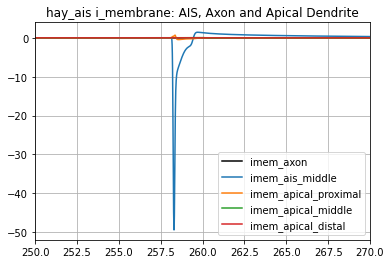

In [29]:
imem_apical_distal   = "IDrest_300.apical_distal.i_membrane"
imem_apical_middle   = "IDrest_300.apical_middle.i_membrane"
imem_apical_proximal = "IDrest_300.apical_proximal.i_membrane"
imem_ais_middle      = "IDrest_300.ais_middle.i_membrane"
imem_axon            = "IDrest_300.axon.i_membrane"

fig, ax = plt.subplots()
ax.plot(responses_release[imem_axon]["time"], responses_release[imem_axon]["voltage"], color="k", label="imem_axon")
ax.plot(responses_release[imem_ais_middle]["time"], responses_release[imem_ais_middle]["voltage"], color="C0", label="imem_ais_middle")
ax.plot(responses_release[imem_apical_proximal]["time"], responses_release[imem_apical_proximal]["voltage"], color="C1", label="imem_apical_proximal")
ax.plot(responses_release[imem_apical_middle]["time"], responses_release[imem_apical_middle]["voltage"], color="C2", label="imem_apical_middle")
ax.plot(responses_release[imem_apical_distal]["time"], responses_release[imem_apical_distal]["voltage"], color="C3", label="imem_apical_distal")
ax.set_xlim([250,270])
ax.grid()
ax.legend()
ax.set_title("hay_ais i_membrane: AIS, Axon and Apical Dendrite")

Text(0.5, 1.0, 'hay_ais i_membrane: Apical Dendrite')

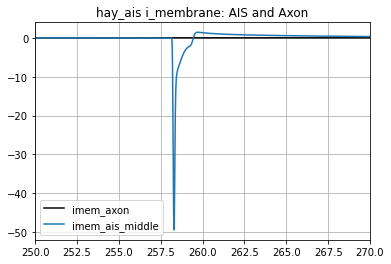

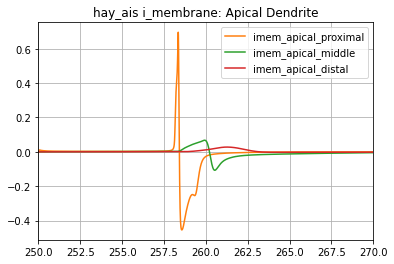

In [30]:
fig, ax = plt.subplots()
ax.plot(responses_release[imem_axon]["time"], responses_release[imem_axon]["voltage"], color="k", label="imem_axon")
ax.plot(responses_release[imem_ais_middle]["time"], responses_release[imem_ais_middle]["voltage"], color="C0", label="imem_ais_middle")
ax.set_xlim([250,270])
ax.grid()
ax.legend()
ax.set_title("hay_ais i_membrane: AIS and Axon")

fig, ax = plt.subplots()
ax.plot(responses_release[imem_apical_proximal]["time"], responses_release[imem_apical_proximal]["voltage"], color="C1", label="imem_apical_proximal")
ax.plot(responses_release[imem_apical_middle]["time"], responses_release[imem_apical_middle]["voltage"], color="C2", label="imem_apical_middle")
ax.plot(responses_release[imem_apical_distal]["time"], responses_release[imem_apical_distal]["voltage"], color="C3", label="imem_apical_distal")
ax.set_xlim([250,270])
ax.grid()
ax.legend()
ax.set_title("hay_ais i_membrane: Apical Dendrite")